# Task 2: Hyperelasticity



In [117]:
from matplotlib import pyplot as plt
import tensorflow as tf
import datetime
now = datetime.datetime.now

import importlib

# %% Own modules
import models as lm
importlib.reload(lm)

<module 'models' from 'f:\\CPShub\\Tutorial\\Task2_Group Xin and Huasen\\train\\models.py'>

### Data import

In [118]:
import numpy as np


data_biaxial = np.loadtxt('../calibration/biaxial.txt')
data_pure_shear = np.loadtxt('../calibration/pure_shear.txt')
data_uniaxial = np.loadtxt('../calibration/uniaxial.txt')


def process_data(data):

    F = data[:, :9].reshape(-1, 3, 3) 
    P = data[:, 9:18].reshape(-1, 3, 3)  
    W = data[:, 18] 
    return F, P, W

# 分别处理三种加载路径的数据
F_biaxial, P_biaxial, W_biaxial = process_data(data_biaxial)
F_pure_shear, P_pure_shear, W_pure_shear = process_data(data_pure_shear)
F_uniaxial, P_uniaxial, W_uniaxial = process_data(data_uniaxial)

# 检查数据
print("Biaxial F:", F_biaxial.shape)
print("Biaxial P:", P_biaxial.shape)
print("Biaxial W:", W_biaxial.shape)

print("Pure Shear F:", F_pure_shear.shape)
print("Pure Shear P:", P_pure_shear.shape)
print("Pure Shear W:", W_pure_shear.shape)

print("Uniaxial F:", F_uniaxial.shape)
print("Uniaxial P:", P_uniaxial.shape)
print("Uniaxial W:", W_uniaxial.shape)


Biaxial F: (199, 3, 3)
Biaxial P: (199, 3, 3)
Biaxial W: (199,)
Pure Shear F: (250, 3, 3)
Pure Shear P: (250, 3, 3)
Pure Shear W: (250,)
Uniaxial F: (199, 3, 3)
Uniaxial P: (199, 3, 3)
Uniaxial W: (199,)


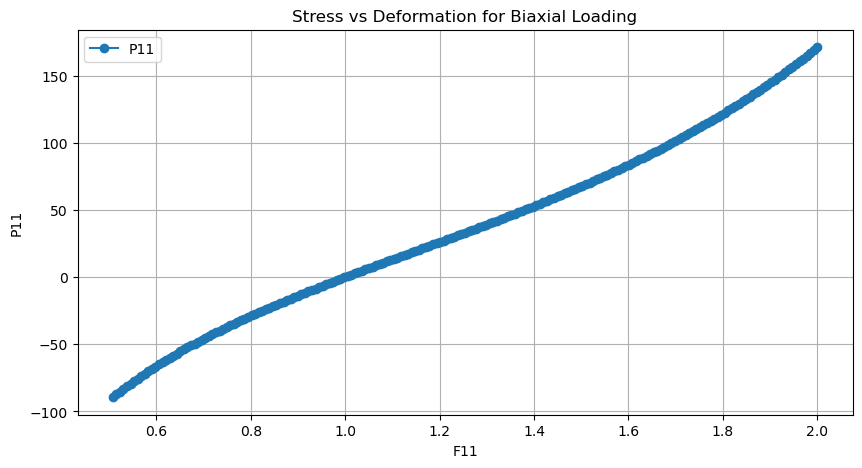

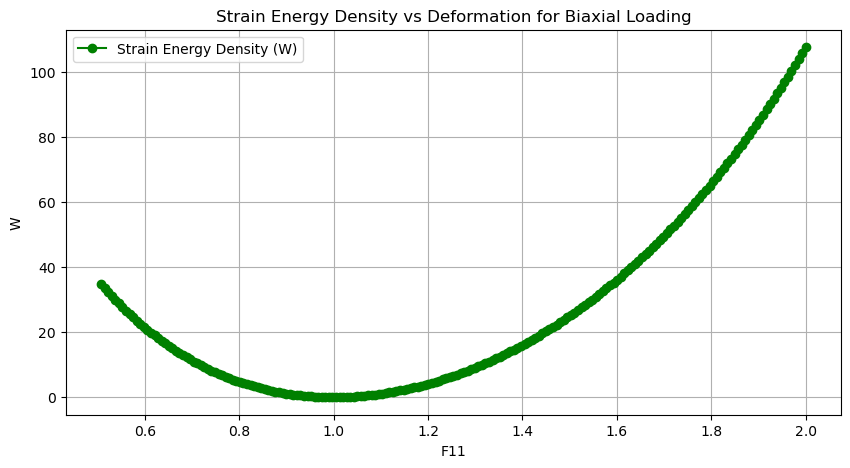

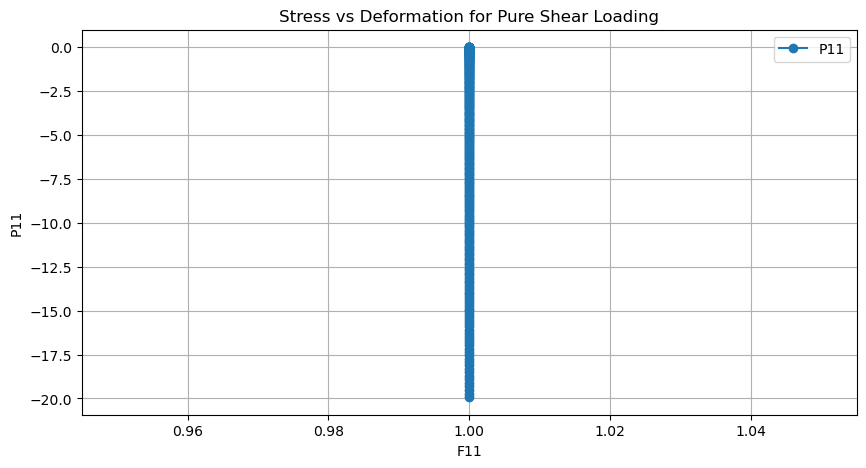

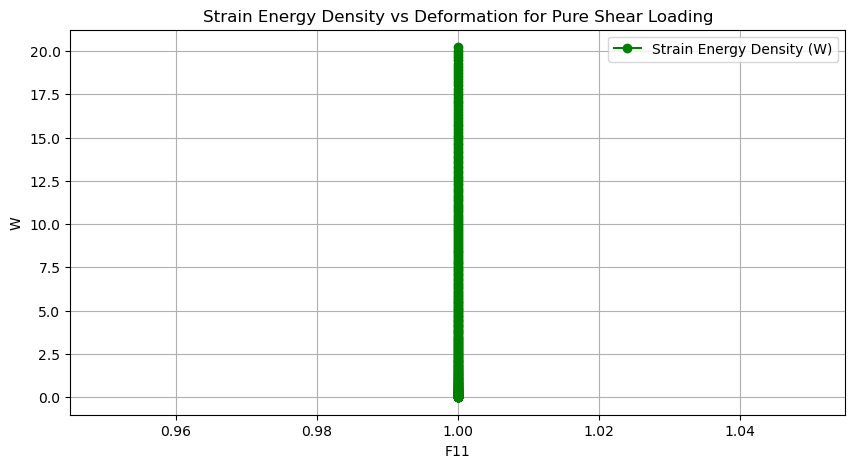

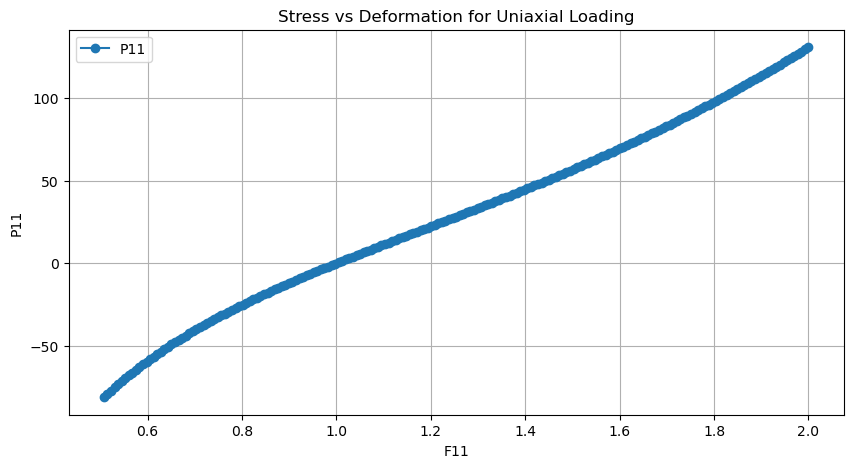

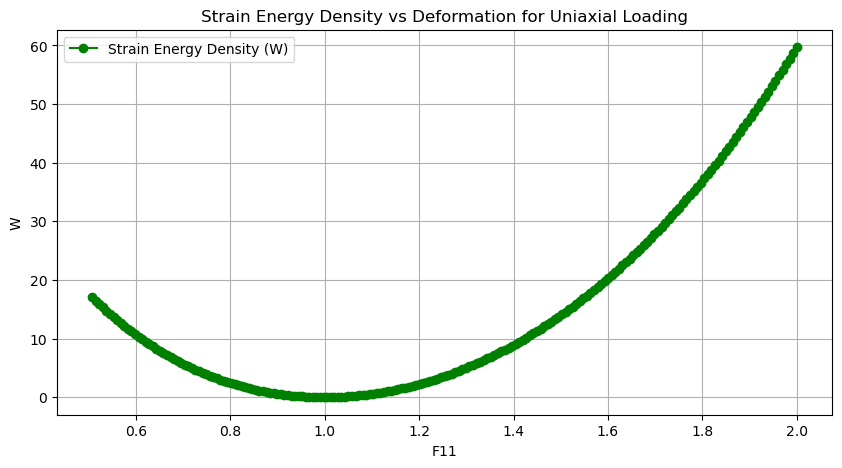

In [119]:
import matplotlib.pyplot as plt

# 可视化函数
def plot_stress_vs_deformation(F, P, W, title):
    # 假设我们主要关注 F11 和 P11 的关系
    F11 = F[:, 0, 0]  # 提取 F11 分量
    P11 = P[:, 0, 0]  # 提取 P11 分量

    # 绘制 P11 与 F11 的关系
    plt.figure(figsize=(10, 5))
    plt.plot(F11, P11, label="P11", marker="o", linestyle="-")
    plt.xlabel("F11")
    plt.ylabel("P11")
    plt.title(f"Stress vs Deformation for {title}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 绘制 W 与 F11 的关系
    plt.figure(figsize=(10, 5))
    plt.plot(F11, W, label="Strain Energy Density (W)", marker="o", linestyle="-", color="green")
    plt.xlabel("F11")
    plt.ylabel("W")
    plt.title(f"Strain Energy Density vs Deformation for {title}")
    plt.legend()
    plt.grid(True)
    plt.show()

# 分别绘制不同加载路径的结果
plot_stress_vs_deformation(F_biaxial, P_biaxial, W_biaxial, title="Biaxial Loading")
plot_stress_vs_deformation(F_pure_shear, P_pure_shear, W_pure_shear, title="Pure Shear Loading")
plot_stress_vs_deformation(F_uniaxial, P_uniaxial, W_uniaxial, title="Uniaxial Loading")


In [120]:
import numpy as np

def compute_invariants(F):
    # F shape is (batch_size, 3, 3)
    batch_size = F.shape[0]
    
    # 计算右 Cauchy-Green 张量 C = F^T * F
    # Using einsum for batch matrix multiplication
    C = np.einsum('bij,bjk->bik', F.transpose(0, 2, 1), F)
    
    # 计算不变量 I1, I2 和 J
    I1 = np.trace(C, axis1=1, axis2=2)  # shape: (batch_size,)
    
    # For I2, compute trace(C@C) with batch operation
    C_square = np.einsum('bij,bjk->bik', C, C)
    I2 = 0.5 * (I1**2 - np.trace(C_square, axis1=1, axis2=2))  # shape: (batch_size,)
    
    # Compute determinant for each matrix in the batch
    J = np.linalg.det(F)  # shape: (batch_size,)
    
    # 定义结构张量 Gti
    Gti = np.array([
        [4, 0, 0],
        [0, 0.5, 0],
        [0, 0, 0.5]
    ])
    
    # 扩展 Gti 到批量维度
    Gti = np.tile(Gti[None, :, :], (batch_size, 1, 1))
    
    # 计算不变量 I4
    I4 = np.trace(np.einsum('bij,bjk->bik', C, Gti), axis1=1, axis2=2)  # shape: (batch_size,)
    
    # 计算 C 的余因子（Cofactor）
    # First compute inverse of C for each matrix in batch
    C_inv = np.linalg.inv(C)
    Cof_C = J[:, None, None] * C_inv.transpose(0, 2, 1)
    
    # 计算不变量 I5
    I5 = np.trace(np.einsum('bij,bjk->bik', Cof_C, Gti), axis1=1, axis2=2)  # shape: (batch_size,)
    
    return I1, J, I4, I5

In [121]:
@tf.function
def neo_hookean_potential(I1, J, I4, I5):
    # 计算应变能密度 W
    W = 8 * I1 + 10 * (J ** 2) - 56 * np.log(J) + 0.2 * (I4 ** 2 + I5 ** 2) - 44
    return W


In [122]:
def process_invariants(data):

    I_1 = data[:, 0]
    J = data[:, 1]
    I_4 = data[:, 2]
    I_5 = data[:, 3]
    return I_1, J, I_4, I_5

In [123]:
I1_biaxial_pred, J_biaxial_pred, I4_biaxial_pred, I5_biaxial_pred = compute_invariants(F_biaxial) 
def check_invariants(pred, data):
    return np.allclose(pred, data, atol=1e-5)
data_biaxial_I = np.loadtxt('../invariants/I_biaxial.txt')
I1_data_biaxial,J_data_biaxial,I4_data_biaxial,I5_data_biaxial = process_invariants(data_biaxial_I)
print("Biaxial I1 Check:", check_invariants(I1_biaxial_pred, I1_data_biaxial))

Biaxial I1 Check: True


In [124]:
import tensorflow as tf


@tf.function
# 计算应力张量 P
def compute_stress_tensor(F, I_1, J, I_4, I_5):
    F = tf.convert_to_tensor(F, dtype=tf.float32)  # 将 F 转换为 TensorFlow 张量
    with tf.GradientTape() as tape:
        tape.watch(F)  # 监视 F
        W = neo_hookean_potential(I_1, J, I_4, I_5)
    P = tape.gradient(W, F)  # 计算 W 对 F 的导数
    return P


In [125]:
import numpy as np

F_train = np.concatenate([F_biaxial.reshape(-1, 9), F_pure_shear.reshape(-1, 9), F_uniaxial.reshape(-1, 9)], axis=0)
P_train = np.concatenate([P_biaxial.reshape(-1, 9), P_pure_shear.reshape(-1, 9), P_uniaxial.reshape(-1, 9)], axis=0)




data_biaxial_test = np.loadtxt('../test/biax_test.txt')
data_mixed_test = np.loadtxt('../test/mixed_test.txt')




F_mixed_test, P_mixed_test, W_mixed_test = process_data(data_mixed_test)
F_biaxial_test, P_biaxial_test, W_biaxial_test = process_data(data_biaxial_test)


F_test = np.concatenate([F_mixed_test.reshape(-1, 9), F_biaxial_test.reshape(-1, 9)], axis=0)
P_test = np.concatenate([P_mixed_test.reshape(-1, 9), P_biaxial_test.reshape(-1, 9)], axis=0)


In [126]:
print(F_train.shape, P_train.shape)

(648, 9) (648, 9)


### Load model

In [127]:
model1 = lm.main()


model1.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 6)]               0         
                                                                 
 private_c_to_p_10 (_C_to_P)  (None, 9)                93        
                                                                 
Total params: 93
Trainable params: 93
Non-trainable params: 0
_________________________________________________________________


Epoch 1/2500
21/21 [==============================] - 1s 14ms/step - loss: 442.8865 - val_loss: 391.7218
Epoch 2/2500
21/21 [==============================] - 0s 7ms/step - loss: 441.7468 - val_loss: 390.4409
Epoch 3/2500
21/21 [==============================] - 0s 8ms/step - loss: 440.5339 - val_loss: 389.1344
Epoch 4/2500
21/21 [==============================] - 0s 8ms/step - loss: 439.2681 - val_loss: 387.7506
Epoch 5/2500
21/21 [==============================] - 0s 8ms/step - loss: 437.8914 - val_loss: 386.1956
Epoch 6/2500
21/21 [==============================] - 0s 5ms/step - loss: 436.3179 - val_loss: 384.4445
Epoch 7/2500
21/21 [==============================] - 0s 6ms/step - loss: 434.6055 - val_loss: 382.3709
Epoch 8/2500
21/21 [==============================] - 0s 6ms/step - loss: 432.5139 - val_loss: 380.1313
Epoch 9/2500
21/21 [==============================] - 0s 6ms/step - loss: 430.2133 - val_loss: 377.2140
Epoch 10/2500
21/21 [==============================] - 0s 6ms/s

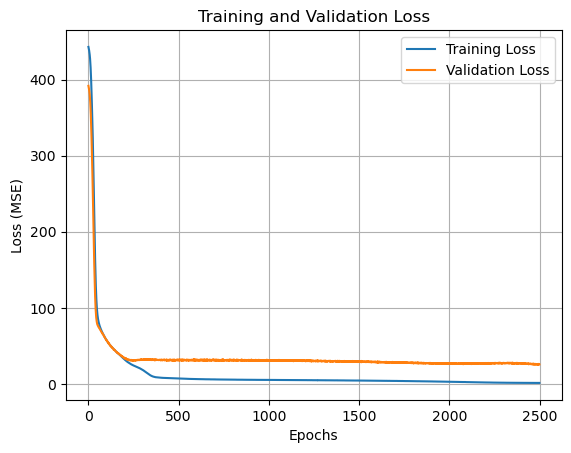

In [128]:
# 训练模型
def convert_F_to_C(F_data):
    # 将 F_data 重塑为 (N, 3, 3) 形状
    F_data = F_data.reshape(-1, 3, 3)
    # 对每个样本计算 C = F^T * F
    C_data = np.einsum('...ji,...jk->...ik', F_data, F_data)
    # 提取对称矩阵 C 的六个独立分量
    C_data_6 = np.stack([C_data[:, 0, 0],  # c11
                         C_data[:, 1, 1],  # c22
                         C_data[:, 2, 2],  # c33
                         C_data[:, 0, 1],  # c12
                         C_data[:, 0, 2],  # c13
                         C_data[:, 1, 2]], axis=-1)  # c23
    return C_data_6

# 转换训练和测试数据
C_train = convert_F_to_C(F_train)
C_test = convert_F_to_C(F_test)


# 模型训练
history = model1.fit(C_train, P_train, epochs=2500, validation_data=(C_test, P_test))

# 训练过程的可视化
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title("Training and Validation Loss")
plt.grid(True)
plt.show()


7/7 [==============================] - 0s 3ms/step


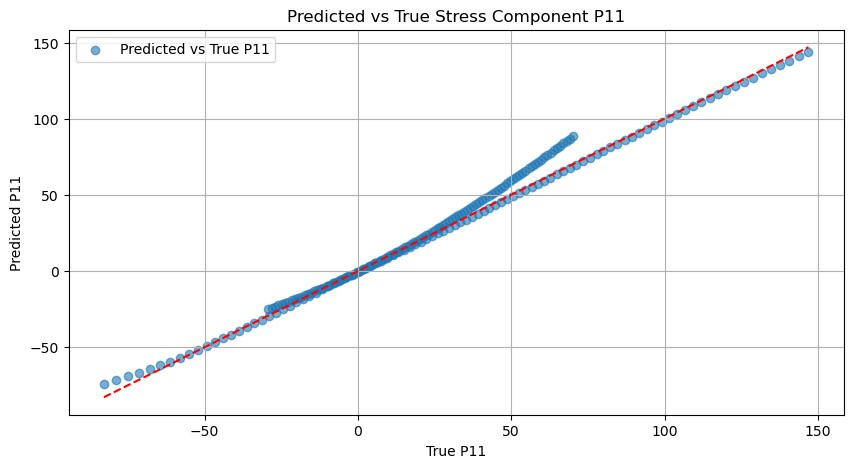

In [129]:
# 预测测试集上的应力分量

P_pred = model1.predict(C_test)

# 可视化真实值与预测值的对比
plt.figure(figsize=(10, 5))
plt.scatter(P_test[:, 0], P_pred[:, 0], label="Predicted vs True P11", alpha=0.6)
plt.xlabel("True P11")
plt.ylabel("Predicted P11")
plt.title("Predicted vs True Stress Component P11")
plt.plot([min(P_test[:, 0]), max(P_test[:, 0])], [min(P_test[:, 0]), max(P_test[:, 0])], color='red', linestyle='--')
plt.legend()
plt.grid(True)
plt.show()


4/4 [==============================] - 0s 2ms/step


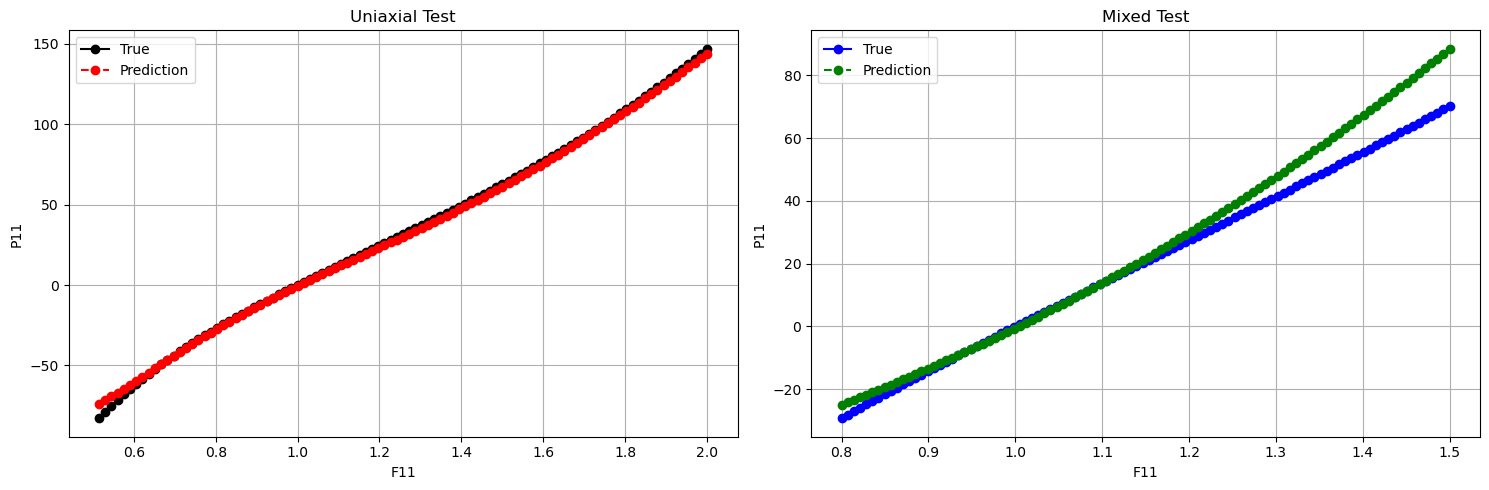

In [130]:
import matplotlib.pyplot as plt

C_biaxial_test = convert_F_to_C(F_biaxial_test.reshape(-1, 9))
C_mixed_test = convert_F_to_C(F_mixed_test.reshape(-1, 9))

P_biaxial_test_pred = model1.predict(C_biaxial_test)

P_mixed_test_pred = model1.predict(C_mixed_test)

def plot_all_stress_vs_deformation(F_biaxial_test, P_biaxial_test, P_biaxial_test_pred, 
                                 F_mixed_test, P_mixed_test, P_mixed_test_pred):

    F11_biaxial_test = F_biaxial_test[:, 0, 0]
    P11_biaxial_test = P_biaxial_test[:, 0, 0]
    P11_biaxial_test_pred = P_biaxial_test_pred[:, 0]

    F11_mixed_test = F_mixed_test[:, 0, 0]
    P11_mixed_test = P_mixed_test[:, 0, 0]
    P11_mixed_test_pred = P_mixed_test_pred[:, 0]


    # 创建一个包含三个子图的图形
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # 绘制双轴加载
    ax1.plot(F11_biaxial_test, P11_biaxial_test, label="True", marker="o", linestyle="-", color="black")
    ax1.plot(F11_biaxial_test, P11_biaxial_test_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax1.set_xlabel("F11")
    ax1.set_ylabel("P11")
    ax1.set_title("Uniaxial Test")
    ax1.legend()
    ax1.grid(True)

    # 绘制纯剪切加载
    ax2.plot(F11_mixed_test, P11_mixed_test, label="True", marker="o", linestyle="-", color="blue")
    ax2.plot(F11_mixed_test, P11_mixed_test_pred, label="Prediction", marker="o", linestyle="--", color="green")
    ax2.set_xlabel("F11")
    ax2.set_ylabel("P11")
    ax2.set_title("Mixed Test")
    ax2.legend()
    ax2.grid(True)

    # 调整子图之间的间距
    plt.tight_layout()
    plt.show()

# 调用函数绘制三种加载路径的结果
plot_all_stress_vs_deformation(F_biaxial_test, P_biaxial_test, P_biaxial_test_pred, 
                             F_mixed_test, P_mixed_test, P_mixed_test_pred)


7/7 [==============================] - 0s 2ms/step


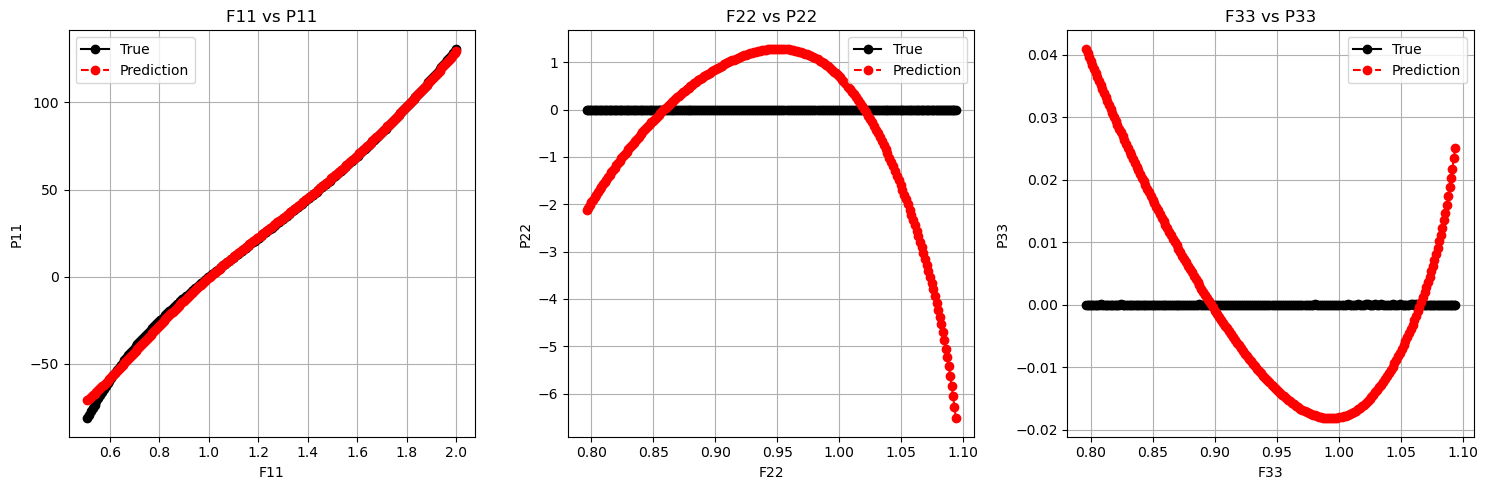

In [131]:
C_uniaxial = convert_F_to_C(F_uniaxial.reshape(-1, 9))
P_uniaxial_pred = model1.predict(C_uniaxial).reshape(-1, 3, 3)
import matplotlib.pyplot as plt
import numpy as np

def plot_all_stress_vs_deformation(F_uniaxial, P_uniaxial, P_uniaxial_pred):
    # 提取 F 和 P 的不同分量
    F11 = F_uniaxial[:, 0, 0]  # 第一列
    F22 = F_uniaxial[:, 1, 1]  
    F33 = F_uniaxial[:, 2, 2] # 第三列

    P11 = P_uniaxial[:, 0, 0]  # 原始 P 的 11 元素
    P22 = P_uniaxial[:, 1, 1]  # 原始 P 的 22 元素
    P33 = P_uniaxial[:, 2, 2]  # 原始 P 的 33 元素

    P11_pred = P_uniaxial_pred[:, 0, 0]  # 预测 P 的 11 元素
    P22_pred = P_uniaxial_pred[:, 1, 1]  # 预测 P 的 22 元素
    P33_pred = P_uniaxial_pred[:, 2, 2]  # 预测 P 的 33 元素

    # 创建绘图
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    ax1 = axes[0]
    ax2 = axes[1]
    ax3 = axes[2]

    ax1.plot(F11, P11, label="True", marker="o", linestyle="-", color="black")
    ax1.plot(F11, P11_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax1.set_xlabel("F11")
    ax1.set_ylabel("P11")
    ax1.set_title("F11 vs P11")
    ax1.legend()
    ax1.grid(True)

    ax2.plot(F22, P22, label="True", marker="o", linestyle="-", color="black")
    ax2.plot(F22, P22_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax2.set_xlabel("F22")
    ax2.set_ylabel("P22")
    ax2.set_title("F22 vs P22")
    ax2.legend()
    ax2.grid(True)

    ax3.plot(F33, P33, label="True", marker="o", linestyle="-", color="black")
    ax3.plot(F33, P33_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax3.set_xlabel("F33")
    ax3.set_ylabel("P33")
    ax3.set_title("F33 vs P33")
    ax3.legend()
    ax3.grid(True)

    # 调整布局
    plt.tight_layout()
    plt.show()

# 调用函数
plot_all_stress_vs_deformation(F_uniaxial, P_uniaxial, P_uniaxial_pred)


### Loss weighting strategy

In [132]:
model2 = lm.main()


model2.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 6)]               0         
                                                                 
 private_c_to_p_11 (_C_to_P)  (None, 9)                93        
                                                                 
Total params: 93
Trainable params: 93
Non-trainable params: 0
_________________________________________________________________


In [133]:
import numpy as np


# 分别计算每种路径的权重
def calculate_path_weight(P_values):
    # 计算每个路径的范数平均值
    norm = np.linalg.norm(P_values, axis=1).mean()
    return 1 / norm  # 使用范数的倒数作为权重

# 获取每种路径的权重
weight_biaxial = calculate_path_weight(P_biaxial)
weight_pure_shear = calculate_path_weight(P_pure_shear)
weight_uniaxial = calculate_path_weight(P_uniaxial)

# 为每条样本分配权重
sample_weights = np.concatenate([
    np.full(P_biaxial.shape[0], weight_biaxial),      # 双轴加载路径权重
    np.full(P_pure_shear.shape[0], weight_pure_shear), # 纯剪切加载路径权重
    np.full(P_uniaxial.shape[0], weight_uniaxial)      # 单轴加载路径权重
])
# 归一化权重，使得权重总和为 1
sample_weights /= np.sum(sample_weights)

# 检查计算结果
print("Sample weights:", sample_weights)
print("Sum of sample weights:", np.sum(sample_weights))

Sample weights: [0.00088266 0.00088266 0.00088266 0.00088266 0.00088266 0.00088266
 0.00088266 0.00088266 0.00088266 0.00088266 0.00088266 0.00088266
 0.00088266 0.00088266 0.00088266 0.00088266 0.00088266 0.00088266
 0.00088266 0.00088266 0.00088266 0.00088266 0.00088266 0.00088266
 0.00088266 0.00088266 0.00088266 0.00088266 0.00088266 0.00088266
 0.00088266 0.00088266 0.00088266 0.00088266 0.00088266 0.00088266
 0.00088266 0.00088266 0.00088266 0.00088266 0.00088266 0.00088266
 0.00088266 0.00088266 0.00088266 0.00088266 0.00088266 0.00088266
 0.00088266 0.00088266 0.00088266 0.00088266 0.00088266 0.00088266
 0.00088266 0.00088266 0.00088266 0.00088266 0.00088266 0.00088266
 0.00088266 0.00088266 0.00088266 0.00088266 0.00088266 0.00088266
 0.00088266 0.00088266 0.00088266 0.00088266 0.00088266 0.00088266
 0.00088266 0.00088266 0.00088266 0.00088266 0.00088266 0.00088266
 0.00088266 0.00088266 0.00088266 0.00088266 0.00088266 0.00088266
 0.00088266 0.00088266 0.00088266 0.00088266 0

In [134]:
C_train = convert_F_to_C(F_train)
C_test = convert_F_to_C(F_test)

Epoch 1/2500
21/21 [==============================] - 1s 14ms/step - loss: 0.5557 - val_loss: 401.0380
Epoch 2/2500
21/21 [==============================] - 0s 7ms/step - loss: 0.5543 - val_loss: 400.1398
Epoch 3/2500
21/21 [==============================] - 0s 6ms/step - loss: 0.5530 - val_loss: 399.4417
Epoch 4/2500
21/21 [==============================] - 0s 7ms/step - loss: 0.5518 - val_loss: 398.8381
Epoch 5/2500
21/21 [==============================] - 0s 7ms/step - loss: 0.5506 - val_loss: 398.2918
Epoch 6/2500
21/21 [==============================] - 0s 7ms/step - loss: 0.5493 - val_loss: 397.6665
Epoch 7/2500
21/21 [==============================] - 0s 7ms/step - loss: 0.5479 - val_loss: 397.1959
Epoch 8/2500
21/21 [==============================] - 0s 6ms/step - loss: 0.5465 - val_loss: 396.7370
Epoch 9/2500
21/21 [==============================] - 0s 6ms/step - loss: 0.5450 - val_loss: 396.1518
Epoch 10/2500
21/21 [==============================] - 0s 6ms/step - loss: 0.5433

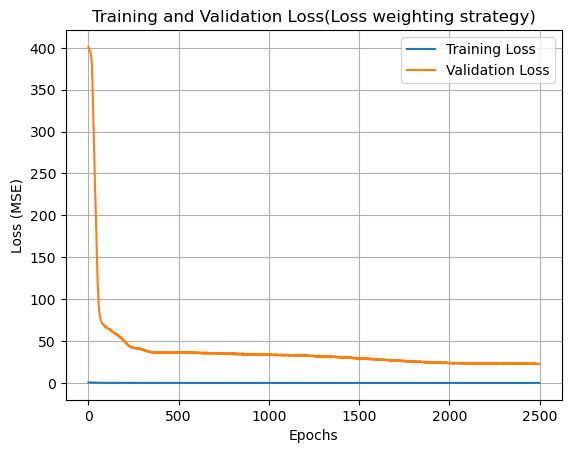

In [135]:
# 训练模型
history = model2.fit(C_train, P_train, epochs=2500, sample_weight=sample_weights, validation_data=(C_test, P_test))

# 训练过程的可视化
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title("Training and Validation Loss(Loss weighting strategy)")
plt.grid(True)
plt.show()

7/7 [==============================] - 0s 2ms/step


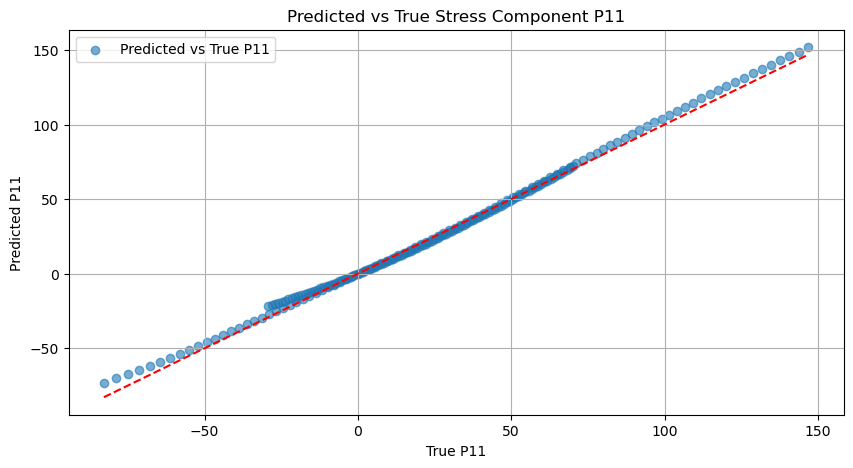

In [140]:
# 预测测试集上的应力分量
P_pred = model2.predict(C_test)

# 可视化真实值与预测值的对比
plt.figure(figsize=(10, 5))
plt.scatter(P_test[:, 0], P_pred[:, 0], label="Predicted vs True P11", alpha=0.6)
plt.xlabel("True P11")
plt.ylabel("Predicted P11")
plt.title("Predicted vs True Stress Component P11")
plt.plot([min(P_test[:, 0]), max(P_test[:, 0])], [min(P_test[:, 0]), max(P_test[:, 0])], color='red', linestyle='--')
plt.legend()
plt.grid(True)
plt.show()


4/4 [==============================] - 0s 2ms/step


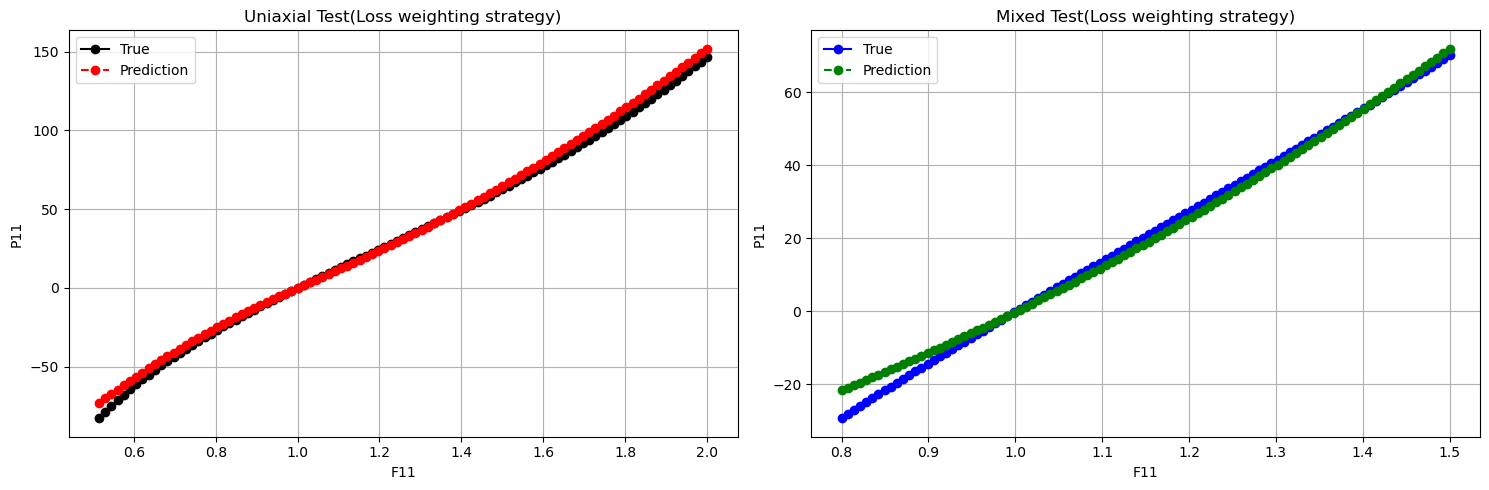

In [141]:
import matplotlib.pyplot as plt

C_biaxial_test = convert_F_to_C(F_biaxial_test.reshape(-1, 9))
C_mixed_test = convert_F_to_C(F_mixed_test.reshape(-1, 9))

P_biaxial_test_pred = model2.predict(C_biaxial_test)

P_mixed_test_pred = model2.predict(C_mixed_test)

def plot_all_stress_vs_deformation(F_biaxial_test, P_biaxial_test, P_biaxial_test_pred, 
                                 F_mixed_test, P_mixed_test, P_mixed_test_pred):

    F11_biaxial_test = F_biaxial_test[:, 0, 0]
    P11_biaxial_test = P_biaxial_test[:, 0, 0]
    P11_biaxial_test_pred = P_biaxial_test_pred[:, 0]

    F11_mixed_test = F_mixed_test[:, 0, 0]
    P11_mixed_test = P_mixed_test[:, 0, 0]
    P11_mixed_test_pred = P_mixed_test_pred[:, 0]


    # 创建一个包含三个子图的图形
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # 绘制双轴加载
    ax1.plot(F11_biaxial_test, P11_biaxial_test, label="True", marker="o", linestyle="-", color="black")
    ax1.plot(F11_biaxial_test, P11_biaxial_test_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax1.set_xlabel("F11")
    ax1.set_ylabel("P11")
    ax1.set_title("Uniaxial Test(Loss weighting strategy)")
    ax1.legend()
    ax1.grid(True)

    # 绘制纯剪切加载
    ax2.plot(F11_mixed_test, P11_mixed_test, label="True", marker="o", linestyle="-", color="blue")
    ax2.plot(F11_mixed_test, P11_mixed_test_pred, label="Prediction", marker="o", linestyle="--", color="green")
    ax2.set_xlabel("F11")
    ax2.set_ylabel("P11")
    ax2.set_title("Mixed Test(Loss weighting strategy)")
    ax2.legend()
    ax2.grid(True)

    # 调整子图之间的间距
    plt.tight_layout()
    plt.show()

# 调用函数绘制三种加载路径的结果
plot_all_stress_vs_deformation(F_biaxial_test, P_biaxial_test, P_biaxial_test_pred, 
                             F_mixed_test, P_mixed_test, P_mixed_test_pred)


7/7 [==============================] - 0s 3ms/step


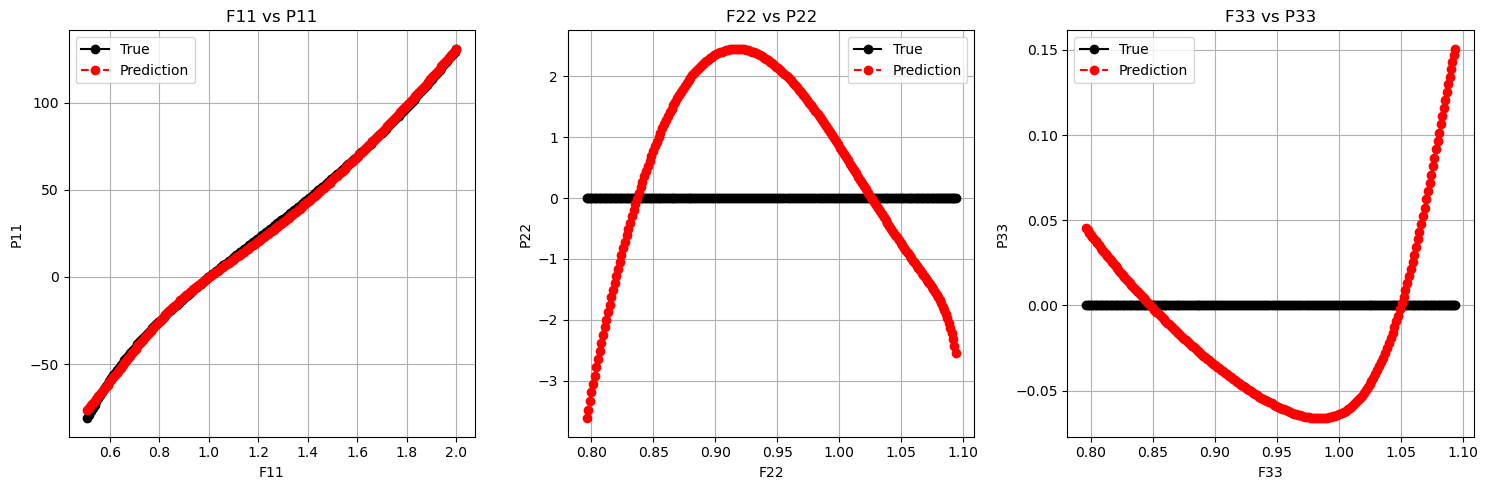

In [143]:
C_uniaxial = convert_F_to_C(F_uniaxial.reshape(-1, 9))
P_uniaxial_pred = model2.predict(C_uniaxial).reshape(-1, 3, 3)
import matplotlib.pyplot as plt
import numpy as np

def plot_all_stress_vs_deformation(F_uniaxial, P_uniaxial, P_uniaxial_pred):
    # 提取 F 和 P 的不同分量
    F11 = F_uniaxial[:, 0, 0]  # 第一列
    F22 = F_uniaxial[:, 1, 1]  
    F33 = F_uniaxial[:, 2, 2] # 第三列

    P11 = P_uniaxial[:, 0, 0]  # 原始 P 的 11 元素
    P22 = P_uniaxial[:, 1, 1]  # 原始 P 的 22 元素
    P33 = P_uniaxial[:, 2, 2]  # 原始 P 的 33 元素

    P11_pred = P_uniaxial_pred[:, 0, 0]  # 预测 P 的 11 元素
    P22_pred = P_uniaxial_pred[:, 1, 1]  # 预测 P 的 22 元素
    P33_pred = P_uniaxial_pred[:, 2, 2]  # 预测 P 的 33 元素

    # 创建绘图
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    ax1 = axes[0]
    ax2 = axes[1]
    ax3 = axes[2]

    ax1.plot(F11, P11, label="True", marker="o", linestyle="-", color="black")
    ax1.plot(F11, P11_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax1.set_xlabel("F11")
    ax1.set_ylabel("P11")
    ax1.set_title("F11 vs P11")
    ax1.legend()
    ax1.grid(True)

    ax2.plot(F22, P22, label="True", marker="o", linestyle="-", color="black")
    ax2.plot(F22, P22_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax2.set_xlabel("F22")
    ax2.set_ylabel("P22")
    ax2.set_title("F22 vs P22")
    ax2.legend()
    ax2.grid(True)

    ax3.plot(F33, P33, label="True", marker="o", linestyle="-", color="black")
    ax3.plot(F33, P33_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax3.set_xlabel("F33")
    ax3.set_ylabel("P33")
    ax3.set_title("F33 vs P33")
    ax3.legend()
    ax3.grid(True)

    # 调整布局
    plt.tight_layout()
    plt.show()

# 调用函数
plot_all_stress_vs_deformation(F_uniaxial, P_uniaxial, P_uniaxial_pred)
